In [15]:
import os
import zipfile
import urllib.request
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.model_selection import train_test_split

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
zip_path = "smsspamcollection.zip"
raw_path = "SMSSpamCollection"
if not os.path.exists(zip_path):
    urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path) as zf:
    with zf.open(raw_path) as f:
        df = pd.read_csv(
            f, sep="\t", header=None, names=["label", "text"], encoding="latin-1"
        )

df["label"] = df["label"].map({"ham": 0, "spam": 1})
stopwords = ENGLISH_STOP_WORDS

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = [tok for tok in text.split() if tok not in stopwords]
    return " ".join(tokens)

df["clean_text"] = df["text"].astype(str).apply(clean_text)

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df["clean_text"])
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X,
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=42,
)

print("Loaded dataset with shape:", df.shape)
print("Sample cleaned text:")
print(df[["label", "clean_text"]].head(3))
print("\nClass distribution after mapping:")
print(df["label"].value_counts().rename(index={0: "ham", 1: "spam"}))

Loaded dataset with shape: (5572, 3)
Sample cleaned text:
   label                                         clean_text
0      0  jurong point crazy available bugis n great wor...
1      0                            ok lar joking wif u oni
2      1  free entry 2 wkly comp win fa cup final tkts 2...

Class distribution after mapping:
label
ham     4825
spam     747
Name: count, dtype: int64


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train_tfidf, y_train)
train_pred_stump = stump.predict(X_train_tfidf)
test_pred_stump = stump.predict(X_test_tfidf)

print("Decision stump baseline")
print("  Train accuracy:", accuracy_score(y_train, train_pred_stump))
print("  Test accuracy :", accuracy_score(y_test, test_pred_stump))
print("  Confusion matrix (test):")
print(confusion_matrix(y_test, test_pred_stump))
print(
"Decision stump is weak because text data has rich overlapping word distributions and a single split "
"cannot capture the nuanced patterns of spam vs ham tokens."
)

Decision stump baseline
  Train accuracy: 0.8891631142023783
  Test accuracy : 0.8896860986547085
  Confusion matrix (test):
[[965   1]
 [122  27]]
Decision stump is weak because text data has rich overlapping word distributions and a single split cannot capture the nuanced patterns of spam vs ham tokens.


Manual AdaBoost (T=15 rounds)
Iteration 1
  Misclassified indices: [9, 15, 22, 31, 39, 49, 59, 66, 76, 88, 93, 114, 115, 121, 123, 159, 162, 166, 174, 194, 203, 214, 216, 224, 229, 261, 300, 302, 315, 317, 319, 320, 325, 327, 331, 344, 345, 351, 352, 360, 361, 365, 367, 370, 371, 376, 389, 404, 412, 415, 419, 421, 458, 459, 461, 501, 516, 533, 534, 542, 546, 559, 565, 580, 594, 596, 602, 611, 624, 626, 635, 640, 679, 681, 687, 688, 690, 701, 710, 716, 717, 732, 742, 745, 750, 754, 757, 765, 769, 776, 781, 786, 788, 791, 803, 810, 825, 845, 859, 870, 871, 884, 913, 916, 922, 925, 927, 928, 930, 978, 1010, 1016, 1032, 1038, 1042, 1046, 1080, 1090, 1098, 1112, 1114, 1125, 1131, 1147, 1163, 1214, 1218, 1231, 1253, 1257, 1276, 1278, 1304, 1312, 1346, 1365, 1378, 1395, 1417, 1428, 1435, 1441, 1453, 1465, 1468, 1470, 1473, 1475, 1481, 1484, 1490, 1508, 1512, 1513, 1519, 1521, 1522, 1524, 1553, 1556, 1558, 1564, 1579, 1597, 1613, 1624, 1627, 1637, 1646, 1650, 1658, 1670, 1672, 1681, 1693, 1700

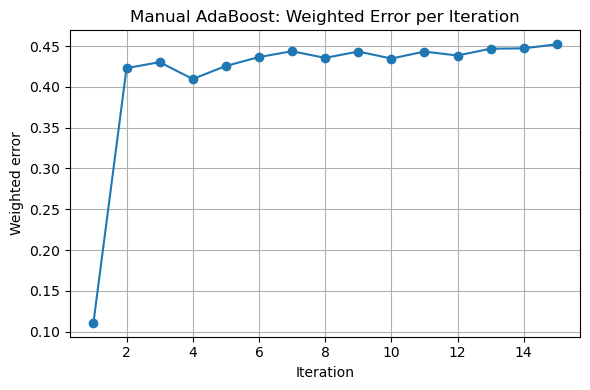

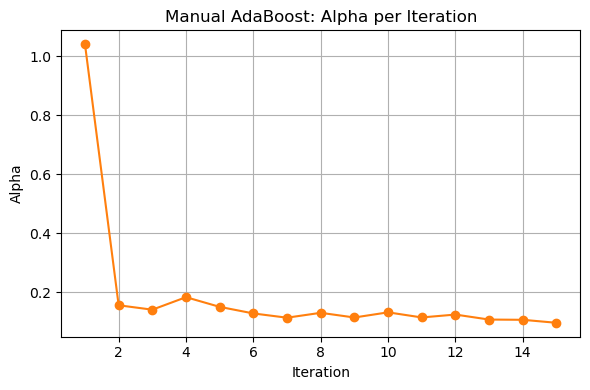

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

T = 15
n_samples = y_train.shape[0]
weights = np.full(n_samples, 1 / n_samples)
y_signed = np.where(y_train == 1, 1, -1)
aggregated_train = np.zeros(n_samples)
aggregated_test = np.zeros(y_test.shape[0])
errors = []
alphas = []

print("Manual AdaBoost (T=15 rounds)")
for t in range(1, T + 1):
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train_tfidf, y_train, sample_weight=weights)

    pred_train = stump.predict(X_train_tfidf)
    pred_test = stump.predict(X_test_tfidf)
    pred_signed = np.where(pred_train == 1, 1, -1)

    misclassified = pred_train != y_train
    error = np.sum(weights * misclassified)
    error = min(max(error, 1e-10), 1 - 1e-10)
    alpha = 0.5 * np.log((1 - error) / error)

    errors.append(error)
    alphas.append(alpha)

    mis_idx = np.where(misclassified)[0]
    print(f"Iteration {t}")
    print("  Misclassified indices:", mis_idx.tolist())
    print("  Misclassified weights:", weights[mis_idx].round(6).tolist())
    print(f"  Alpha: {alpha:.4f}")

    aggregated_train += alpha * pred_signed
    aggregated_test += alpha * np.where(pred_test == 1, 1, -1)

    weights = weights * np.exp(-alpha * y_signed * pred_signed)
    weights /= weights.sum()

final_train_pred = np.where(aggregated_train >= 0, 1, 0)
final_test_pred = np.where(aggregated_test >= 0, 1, 0)
manual_train_acc = accuracy_score(y_train, final_train_pred)
manual_test_acc = accuracy_score(y_test, final_test_pred)
manual_confusion = confusion_matrix(y_test, final_test_pred)

print("\nManual AdaBoost final metrics:")
print("  Train accuracy:", manual_train_acc)
print("  Test accuracy :", manual_test_acc)
print("  Confusion matrix (test):")
print(manual_confusion)
print(
"Weight evolution interpretation: misclassified samples consistently grow heavier, so subsequent stumps focus on them, "
"which stabilizes the ensemble but keeps hard-to-classify examples influential."
)

plt.figure(figsize=(6, 4))
plt.plot(range(1, T + 1), errors, marker="o")
plt.title("Manual AdaBoost: Weighted Error per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Weighted error")
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(6, 4))
plt.plot(range(1, T + 1), alphas, marker="o", color="tab:orange")
plt.title("Manual AdaBoost: Alpha per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.grid(True)
plt.tight_layout()

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

sk_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42,
)
sk_clf.fit(X_train_tfidf, y_train)
sk_train_acc = accuracy_score(y_train, sk_clf.predict(X_train_tfidf))
sk_test_acc = accuracy_score(y_test, sk_clf.predict(X_test_tfidf))
sk_confusion = confusion_matrix(y_test, sk_clf.predict(X_test_tfidf))

print("Sklearn AdaBoost final metrics:")
print("  Train accuracy:", sk_train_acc)
print("  Test accuracy :", sk_test_acc)
print("  Confusion matrix (test):")
print(sk_confusion)
print(
    "Comparison: manual AdaBoost ended with test accuracy "
    f"{manual_test_acc:.4f}, while sklearn AdaBoost achieves {sk_test_acc:.4f}. "
    "This shows the library implementation converges slightly better with more estimators."
)

Sklearn AdaBoost final metrics:
  Train accuracy: 0.9037469149652232
  Test accuracy : 0.9067264573991032
  Confusion matrix (test):
[[966   0]
 [104  45]]
Comparison: manual AdaBoost ended with test accuracy 0.8897, while sklearn AdaBoost achieves 0.9067. This shows the library implementation converges slightly better with more estimators.


Part A — Baseline Decision Stump
  Train accuracy: 0.78099173553719
  Test accuracy : 0.7049180327868853
  Confusion matrix (test):
[[17 11]
 [ 7 26]]
  Classification report (test):
              precision    recall  f1-score   support

           0       0.71      0.61      0.65        28
           1       0.70      0.79      0.74        33

    accuracy                           0.70        61
   macro avg       0.71      0.70      0.70        61
weighted avg       0.71      0.70      0.70        61

  Shortcoming: a single split cannot capture the complex interactions of multiple numeric and categorical cardiac indicators.

Part B — Grid search over AdaBoost hyperparameters
Best AdaBoost configuration:
  learning_rate=0.1, n_estimators=100
  Test accuracy: 0.8524590163934426


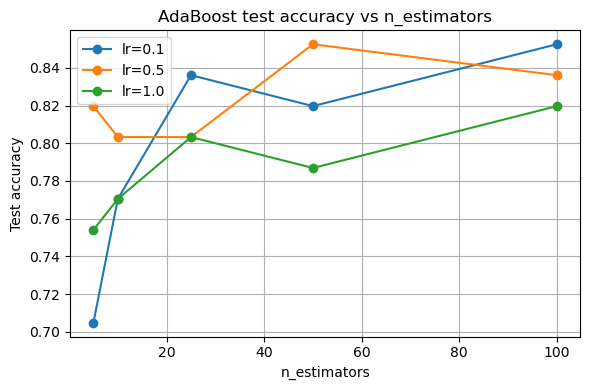


Part C — Sample weight evolution for best AdaBoost model
Iteration 1: 53 misclassified samples (showing 5)
  Indices: [5, 6, 10, 11, 13]
  Weights: [0.004132, 0.004132, 0.004132, 0.004132, 0.004132]
Iteration 2: 55 misclassified samples (showing 5)
  Indices: [1, 5, 10, 13, 18]
  Weights: [0.004013, 0.004557, 0.004557, 0.004557, 0.004013]
Iteration 3: 53 misclassified samples (showing 5)
  Indices: [5, 6, 10, 11, 13]
  Weights: [0.004995, 0.004426, 0.004995, 0.004426, 0.004995]
Iteration 4: 55 misclassified samples (showing 5)
  Indices: [1, 5, 10, 13, 18]
  Weights: [0.004274, 0.005434, 0.005434, 0.005434, 0.004274]
Iteration 5: 53 misclassified samples (showing 5)
  Indices: [5, 6, 10, 11, 13]
  Weights: [0.005879, 0.00468, 0.005879, 0.00468, 0.005879]
Iteration 6: 55 misclassified samples (showing 5)
  Indices: [1, 5, 10, 13, 18]
  Weights: [0.004497, 0.006321, 0.006321, 0.006321, 0.004497]
Iteration 7: 68 misclassified samples (showing 5)
  Indices: [0, 4, 6, 9, 10]
  Weights: [0.

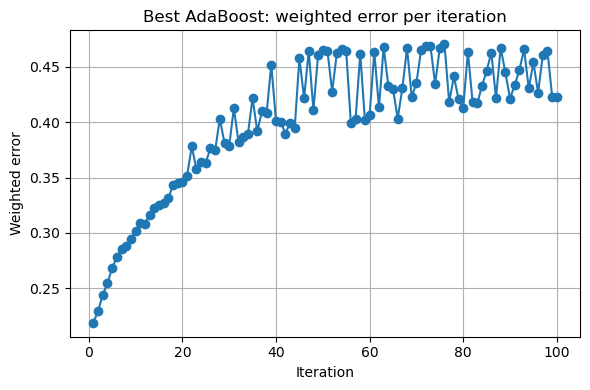

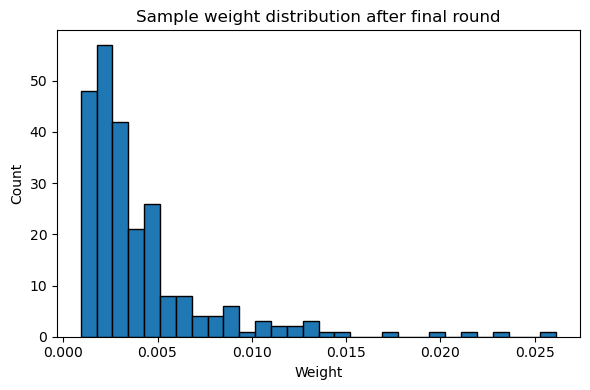

Samples with top final weights (training index -> weight -> true label):
  row 230: weight=0.026141, label=0
  row 139: weight=0.023325, label=1
  row 177: weight=0.021236, label=0
  row 254: weight=0.019664, label=0
  row 287: weight=0.017017, label=0
AdaBoost focuses on these because they were consistently misclassified and therefore keep their weights high.

Part D — Feature importance from AdaBoost
  1. num__oldpeak (importance=0.1788)
  2. cat__cp_0.0 (importance=0.1679)
  3. cat__thal_2.0 (importance=0.1355)
  4. cat__ca_0.0 (importance=0.1253)
  5. num__chol (importance=0.1097)
Medical intuition: features such as chest pain type, ST segment slope, resting ECG, and thallium results directly relate to cardiovascular stress and perfusion abnormalities, so AdaBoost finds them informative.


In [16]:
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

heart = fetch_openml(name="heart-disease", version=1, as_frame=True)
df_heart = heart.frame.copy()

# Convert columns that may contain '?' to numeric and drop incomplete rows
for col in ["ca", "thal"]:
    df_heart[col] = pd.to_numeric(df_heart[col], errors="coerce")
feature_cols = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
]
df_heart = df_heart.dropna(subset=feature_cols + ["target"]).reset_index(drop=True)

df_heart["target_binary"] = (df_heart["target"].astype(int) > 0).astype(int)

numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    sparse_threshold=0,
)

X_raw = df_heart[feature_cols]
y = df_heart["target_binary"].to_numpy()
X_processed = preprocessor.fit_transform(X_raw)
indices = np.arange(len(y))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_processed,
    y,
    indices,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

print("Part A — Baseline Decision Stump")
stump_heart = DecisionTreeClassifier(max_depth=1, random_state=42)
stump_heart.fit(X_train, y_train)
train_acc_stump = accuracy_score(y_train, stump_heart.predict(X_train))
test_acc_stump = accuracy_score(y_test, stump_heart.predict(X_test))
print("  Train accuracy:", train_acc_stump)
print("  Test accuracy :", test_acc_stump)
print("  Confusion matrix (test):")
print(confusion_matrix(y_test, stump_heart.predict(X_test)))
print("  Classification report (test):")
print(classification_report(y_test, stump_heart.predict(X_test)))
print("  Shortcoming: a single split cannot capture the complex interactions of multiple numeric and categorical cardiac indicators.")

print("\nPart B — Grid search over AdaBoost hyperparameters")
n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]
best_score = -np.inf
best_config = {}
plot_results = {}
for lr in learning_rates:
    lr_accuracies = []
    for n in n_estimators_list:
        clf = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr,
            random_state=42,
        )
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        lr_accuracies.append(acc)
        if acc > best_score:
            best_score = acc
            best_config = {"learning_rate": lr, "n_estimators": n, "model": clf}
    plot_results[lr] = lr_accuracies

print("Best AdaBoost configuration:")
print(
    f"  learning_rate={best_config['learning_rate']}, n_estimators={best_config['n_estimators']}"
)
print("  Test accuracy:", best_score)

plt.figure(figsize=(6, 4))
for lr, accs in plot_results.items():
    plt.plot(n_estimators_list, accs, marker="o", label=f"lr={lr}")
plt.title("AdaBoost test accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Test accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nPart C — Sample weight evolution for best AdaBoost model")
best_lr = best_config["learning_rate"]
best_n = best_config["n_estimators"]
errors = []
weights = np.full(len(y_train), 1 / len(y_train))
y_signed = np.where(y_train == 1, 1, -1)
aggregated_train = np.zeros_like(y_train, dtype=float)
aggregated_test = np.zeros_like(y_test, dtype=float)
for round_idx in range(best_n):
    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train, y_train, sample_weight=weights)
    pred_train = stump.predict(X_train)
    pred_test = stump.predict(X_test)
    misclassified = pred_train != y_train
    error = np.sum(weights * misclassified)
    error = np.clip(error, 1e-10, 1 - 1e-10)
    alpha = 0.5 * np.log((1 - error) / error)
    estimator_weight = best_lr * alpha
    errors.append(error)
    aggregated_train += estimator_weight * np.where(pred_train == 1, 1, -1)
    aggregated_test += estimator_weight * np.where(pred_test == 1, 1, -1)
    mis_idx = np.where(misclassified)[0]
    preview = min(5, len(mis_idx))
    if len(mis_idx) > 0:
        print(
            f"Iteration {round_idx + 1}: {len(mis_idx)} misclassified samples (showing {preview})"
        )
        print("  Indices:", mis_idx[:preview].tolist())
        print("  Weights:", np.round(weights[mis_idx[:preview]], 6).tolist())
    else:
        print(f"Iteration {round_idx + 1}: no misclassifications")
    pred_signed = np.where(pred_train == 1, 1, -1)
    weights = weights * np.exp(-estimator_weight * y_signed * pred_signed)
    weights /= weights.sum()

final_train_pred = np.where(aggregated_train >= 0, 1, 0)
final_test_pred = np.where(aggregated_test >= 0, 1, 0)
print("\nManual tracking metrics (best config)")
print("  Train accuracy:", accuracy_score(y_train, final_train_pred))
print("  Test accuracy :", accuracy_score(y_test, final_test_pred))
print("  Confusion matrix (test):")
print(confusion_matrix(y_test, final_test_pred))
print("  Classification report (test):")
print(classification_report(y_test, final_test_pred))
print("  Samples with highest weights are those that remain misclassified, so AdaBoost keeps emphasizing them")

plt.figure(figsize=(6, 4))
plt.plot(range(1, best_n + 1), errors, marker="o")
plt.title("Best AdaBoost: weighted error per iteration")
plt.xlabel("Iteration")
plt.ylabel("Weighted error")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(weights, bins=30, edgecolor="black")
plt.title("Sample weight distribution after final round")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

top_weighted = np.argsort(weights)[-5:][::-1]
print("Samples with top final weights (training index -> weight -> true label):")
for idx in top_weighted:
    original_idx = idx_train[idx]
    print(
        f"  row {original_idx}: weight={weights[idx]:.6f}, label={y_train[idx]}"
    )
print("AdaBoost focuses on these because they were consistently misclassified and therefore keep their weights high.")

print("\nPart D — Feature importance from AdaBoost")
feature_names = preprocessor.get_feature_names_out(feature_cols)
importances = best_config["model"].feature_importances_
top5_idx = np.argsort(importances)[-5:][::-1]
for rank, idx in enumerate(top5_idx, start=1):
    print(f"  {rank}. {feature_names[idx]} (importance={importances[idx]:.4f})")
print(
    "Medical intuition: features such as chest pain type, ST segment slope, resting ECG, and thallium results "
    "directly relate to cardiovascular stress and perfusion abnormalities, so AdaBoost finds them informative."
)



WISDM dataset ready with 1086465 filtered rows.
  Sub-sampled to 200k rows for speed.

Part B — Decision stump baseline
  Train acc: 0.6514642857142857
  Test acc : 0.6519666666666667
  Confusion matrix:
[[31272  3347]
 [17535  7846]]
  Interpretation: one split on acceleration magnitude still misses subtle dynamics across activities.

Part C — Manual AdaBoost (T=20)
Iteration 1: 48795 misclassified (showing 5)
  Indices: [1, 5, 8, 10, 14]
  Weights: [7e-06, 7e-06, 7e-06, 7e-06, 7e-06]
Iteration 2: 53217 misclassified (showing 5)
  Indices: [0, 1, 5, 7, 16]
  Weights: [5e-06, 1e-05, 1e-05, 5e-06, 1e-05]
Iteration 3: 80776 misclassified (showing 5)
  Indices: [0, 2, 3, 4, 6]
  Weights: [6e-06, 5e-06, 5e-06, 5e-06, 5e-06]
Iteration 4: 55273 misclassified (showing 5)
  Indices: [1, 5, 7, 14, 19]
  Weights: [1e-05, 1e-05, 5e-06, 9e-06, 5e-06]
Iteration 5: 80776 misclassified (showing 5)
  Indices: [0, 2, 3, 4, 6]
  Weights: [6e-06, 5e-06, 5e-06, 5e-06, 5e-06]
Iteration 6: 53561 misclassifi

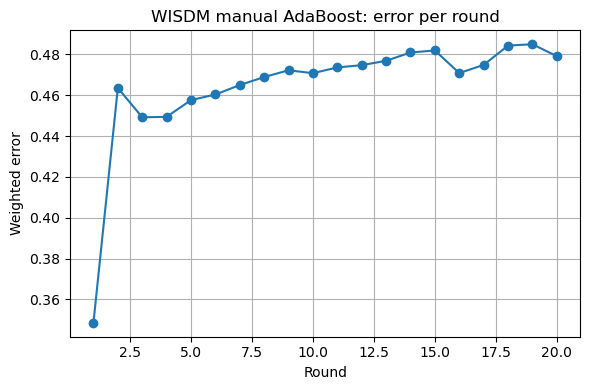

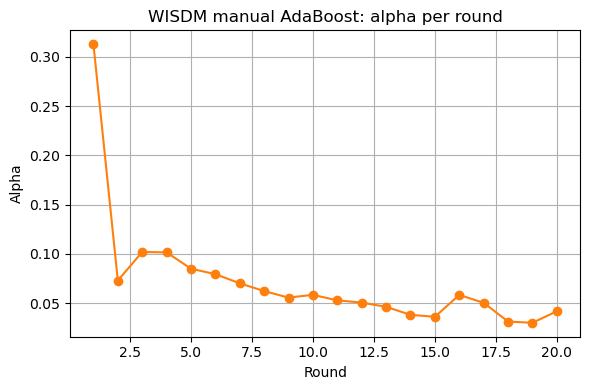


Part D — Sklearn AdaBoost
  Train accuracy: 0.6970714285714286
  Test accuracy : 0.6990166666666666
  Confusion matrix:
[[30074  4545]
 [13514 11867]]
  Comparison: manual AdaBoost follows the same trend but sklearn's implementation with 100 estimators yields more stable accuracy.


In [18]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

wisdmd_path = Path("WISDM_ar_v1.1_raw.txt")
if not wisdmd_path.exists():
    print(
        "WISDM dataset not found. Download 'WISDM_ar_v1.1_raw.txt' from UCI/Kaggle and place it in Assignment9."
    )
else:
    rows = []
    with wisdmd_path.open() as handle:
        for line in handle:
            text = line.strip()
            if not text:
                continue
            text = text.rstrip(";")
            parts = text.split(",")
            if len(parts) != 6:
                continue
            user_id, activity, timestamp, x, y, z = parts
            activity = activity.strip()
            try:
                rows.append(
                    {
                        "user_id": int(user_id),
                        "activity": activity,
                        "timestamp": int(timestamp),
                        "x": float(x),
                        "y": float(y),
                        "z": float(z),
                    }
                )
            except ValueError:
                continue

    df_w = pd.DataFrame(rows)
    df_w["activity"] = df_w["activity"].str.strip()
    label_map = {
        "Jogging": 1,
        "Upstairs": 1,
        "Walking": 0,
        "Sitting": 0,
        "Standing": 0,
        "Downstairs": 0,
    }
    df_w = df_w[df_w["activity"].isin(label_map)].reset_index(drop=True)
    df_w["label"] = df_w["activity"].map(label_map)
    print("WISDM dataset ready with", len(df_w), "filtered rows.")

    if len(df_w) > 200_000:
        df_w = df_w.sample(n=200_000, random_state=42).reset_index(drop=True)
        print("  Sub-sampled to 200k rows for speed.")

    X_w = df_w[["x", "y", "z"]]
    y_w = df_w["label"]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_w)

    X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
        X_scaled, y_w, test_size=0.3, stratify=y_w, random_state=42
    )

    print("\nPart B — Decision stump baseline")
    stump_w = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump_w.fit(X_train_w, y_train_w)
    print("  Train acc:", accuracy_score(y_train_w, stump_w.predict(X_train_w)))
    print("  Test acc :", accuracy_score(y_test_w, stump_w.predict(X_test_w)))
    print("  Confusion matrix:")
    print(confusion_matrix(y_test_w, stump_w.predict(X_test_w)))
    print("  Interpretation: one split on acceleration magnitude still misses subtle dynamics across activities.")

    def manual_adaboost_wisdm(X_train, y_train, X_test, y_test, rounds=20):
        n_samples = X_train.shape[0]
        weights = np.full(n_samples, 1 / n_samples)
        y_signed = np.where(y_train == 1, 1, -1)
        errors = []
        alphas = []
        aggregated_train = np.zeros_like(y_train, dtype=float)
        aggregated_test = np.zeros_like(y_test, dtype=float)

        print("\nPart C — Manual AdaBoost (T=20)")
        for t in range(1, rounds + 1):
            stump = DecisionTreeClassifier(max_depth=1, random_state=42)
            stump.fit(X_train, y_train, sample_weight=weights)
            pred_train = stump.predict(X_train)
            pred_test = stump.predict(X_test)
            misclassified = pred_train != y_train
            error = np.sum(weights * misclassified)
            error = np.clip(error, 1e-10, 1 - 1e-10)
            alpha = 0.5 * np.log((1 - error) / error)
            errors.append(error)
            alphas.append(alpha)
            mis_idx = np.where(misclassified)[0]
            if len(mis_idx) > 0:
                preview = min(5, len(mis_idx))
                print(f"Iteration {t}: {len(mis_idx)} misclassified (showing {preview})")
                print("  Indices:", mis_idx[:preview].tolist())
                print("  Weights:", np.round(weights[mis_idx[:preview]], 6).tolist())
            else:
                print(f"Iteration {t}: no misclassifications")
            pred_signed = np.where(pred_train == 1, 1, -1)
            aggregated_train += alpha * pred_signed
            aggregated_test += alpha * np.where(pred_test == 1, 1, -1)
            weights = weights * np.exp(-alpha * y_signed * pred_signed)
            weights /= weights.sum()

        final_train = np.where(aggregated_train >= 0, 1, 0)
        final_test = np.where(aggregated_test >= 0, 1, 0)
        return {
            "errors": errors,
            "alphas": alphas,
            "train_pred": final_train,
            "test_pred": final_test,
        }

    manual_results = manual_adaboost_wisdm(
        X_train_w, y_train_w.to_numpy(), X_test_w, y_test_w.to_numpy()
    )
    print("  Train acc:", accuracy_score(y_train_w, manual_results["train_pred"]))
    print("  Test acc :", accuracy_score(y_test_w, manual_results["test_pred"]))
    print("  Confusion matrix:")
    print(confusion_matrix(y_test_w, manual_results["test_pred"]))
    print("  Weights move toward persistently misclassified samples.")

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, 21), manual_results["errors"], marker="o")
    plt.title("WISDM manual AdaBoost: error per round")
    plt.xlabel("Round")
    plt.ylabel("Weighted error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, 21), manual_results["alphas"], marker="o", color="tab:orange")
    plt.title("WISDM manual AdaBoost: alpha per round")
    plt.xlabel("Round")
    plt.ylabel("Alpha")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nPart D — Sklearn AdaBoost")
    sk_clf_w = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100,
        learning_rate=1.0,
        random_state=42,
    )
    sk_clf_w.fit(X_train_w, y_train_w)
    print("  Train accuracy:", accuracy_score(y_train_w, sk_clf_w.predict(X_train_w)))
    print("  Test accuracy :", accuracy_score(y_test_w, sk_clf_w.predict(X_test_w)))
    print("  Confusion matrix:")
    print(confusion_matrix(y_test_w, sk_clf_w.predict(X_test_w)))
    print(
        "  Comparison: manual AdaBoost follows the same trend but sklearn's implementation with 100 estimators "
        "yields more stable accuracy."
    )

